In [1]:
import numpy as np
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
import json
from urllib import request, parse

from PIL import Image
from matplotlib.patches import Ellipse, Circle
from sklearn.utils import shuffle
from tensorflow.python.platform import gfile

In [2]:
EYE_W = 80
EYE_H = 60
def getEye4Image(image):
#     image = Image.open(imageFilePath)
#     image  = cv2.imread(imageFilePath, cv2.IMREAD_COLOR)
    img = cv2.GaussianBlur(image, (5,5), 1.5);
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
    
    g = Image.fromarray(cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB))
    faceCascade = cv2.CascadeClassifier('../model/haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(image, 1.1,2, cv2.CASCADE_SCALE_IMAGE,minSize=(100,100))
    
    if len(faces) > 0:
        size = 0
        n = 0
        for i in range(len(faces)):
            if size < faces[i][2]:
                size = faces[i][2]
                n = i
        fx = faces[n][0]
        fy = faces[n][1]
        fw = faces[n][2]
        fh = faces[n][3]
        face = image[fy:fy+fh, fx:fx+fw]
        eyeCascade = cv2.CascadeClassifier('../model/haarcascade_lefteye_2splits.xml')
        eyes = eyeCascade.detectMultiScale(face, 1.2,2)
#         print('eye:',len(eyes))
        if len(eyes) > 1:
            lr = 1024
            for i in range(len(eyes)):
                if lr > eyes[i][0]:
                    lr = eyes[i][0]
                    n = i
            w = eyes[n][2]
            h = eyes[n][3]
            x = fx + eyes[n][0]
            y = fy + eyes[n][1] + h/4
            h = h*3/4
#             print(x, y, w, h)
        else:
            eyeData = None
            eyeImage = None
            eyeX = None
            eyeY = None
            eyeW = None
            eyeH = None
            return eyeData,eyeImage,eyeX,eyeY,eyeW,eyeH
    else:
        eyeData = None
        eyeImage = None
        eyeX = None
        eyeY = None
        eyeW = None
        eyeH = None
        return eyeData,eyeImage,eyeX,eyeY,eyeW,eyeH
    eyeX = x
    eyeY = y
    
    eyeW = w
    eyeH = int(w*3/4.0)
    
    eyeBox = (eyeX, eyeY, eyeX+eyeW, eyeY+eyeH)

    eye = g.crop(eyeBox)
    eyeImage = eye.resize((EYE_W,EYE_H),Image.ANTIALIAS)
    eyeGray = eyeImage.convert('L')
    eyeData = np.array(eyeGray)
#     plt.figure(figsize=(6,2))
#     ax = plt.subplot(121)
#     plt.imshow(eyeImage)
#     plt.show()
    return eyeData,eyeImage,eyeX,eyeY,eyeW,eyeH

def getTestData(eye):
    data_list = []
    data = eye/255.0
    data_list.append(data)
    X = np.vstack(data_list)
    X = X.reshape(-1, EYE_W*EYE_H, 1)
    return X

def display(image):
    eyeData, eyeImage, eyeX, eyeY, eyeW, eyeH = getEye4Image(image)
    if eyeX == None:
        return
    xyc = ['RAX','RAY','yellow',
          'ROX','ROY','red',
          'RBX','RBY','blue',
          'RUX','RUY','green',
          'RDX','RDY','aqua',
          
#           'LAX','LAY','yellow',
#           'LOX','LOY','red',
#           'LBX','LBY','blue',
#           'LUX','LUY','green',
#           'LDX','LDY','aqua'
    ]
    eye_label = []
    test_list = getTestData(eyeData)
    with tf.gfile.FastGFile('../data/eye_17000.pb', 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    with tf.Session() as sess:
        out_tensor_name = 'layer/out/p/output:0'
        out_data_tensor = sess.graph.get_tensor_by_name(out_tensor_name)
        batch_xs = test_list[0:1,...]
#         print(batch_xs.shape)
        batch_xs = batch_xs.reshape(-1, EYE_W*EYE_H)
        data_tensor = sess.run(out_data_tensor,{'input/x:0':batch_xs,'input/k:0':1.0})
#         print(data_tensor)
    plt.figure(figsize=(6,2))
    ax = plt.subplot(121)
    plt.imshow(eyeImage)
    for i in range(5):
#         px = data_tensor[0][2*i]*EYE_W #flag[xyc[i*3]] - eyeX
#         py = data_tensor[0][2*i+1]*EYE_W #flag[xyc[i*3+1]] - eyeY
        px = data_tensor[0][2*i]*EYE_W/2.0 + EYE_W/2.0 #flag[xyc[i*3]] - eyeX
        py = data_tensor[0][2*i+1]*EYE_W/2.0 + EYE_W/2.0 #flag[xyc[i*3+1]] - eyeY
        plt.plot(int(px), int(py), '.', label='point', color=xyc[i*3+2])
    plt.show()
    sx = data_tensor[0][4] -  data_tensor[0][2]
    sx = sx * EYE_W/2
    sy = data_tensor[0][5] -  data_tensor[0][3]
    sy = sy * EYE_W/2
    print(sx, sy)

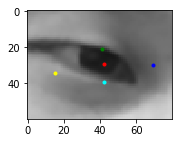

26.0786104202 1.30501389503


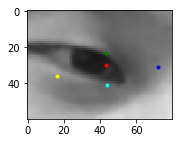

28.159327507 0.671992897987


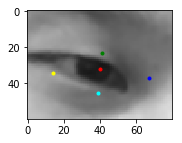

26.6118431091 5.16763031483


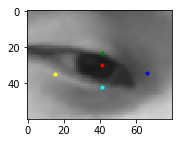

25.31935215 3.70256185532


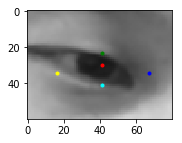

25.5927109718 3.35134208202


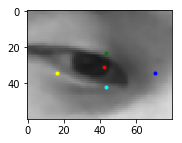

27.7712774277 2.59173452854


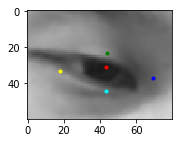

26.5510702133 5.47109782696


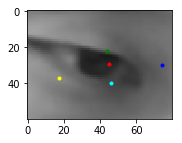

28.5120344162 0.59977889061


In [4]:
cap = cv2.VideoCapture(0)
cap.set(3,768)
cap.set(4,576)
cap.set(1,10.0)
for i in range(10):
    ret,frame = cap.read()
#     print(type(frame))
    img = cv2.cvtColor(np.asarray(frame),cv2.COLOR_RGB2BGR)
    display(img)
#     plt.figure(figsize=(8,6))
#     ax = plt.subplot(121)
#     plt.imshow(img)
#     plt.show()
cap.release()
# cv2.destroyAllWindows()